In [10]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = ["SimSun", "Times New Roman"]  
plt.rcParams["font.family"] = ["SimHei", "Times New Roman"]
plt.rcParams["axes.unicode_minus"] = False  

# 高斯过程回归GPR
## np.random.normal(0, 20, n_samples) 的作用是生成一个包含 n_samples 个服从正态分布的随机数的数组
- 0：均值（中心值）；
- 20：标准差（控制数据分布的离散程度）；
- n_samples：生成的随机数个数。

## 测试

In [11]:
np.random.seed(42)
n_samples = 100
# 4种原材料百分比（和为100%）
X = np.random.dirichlet(np.ones(4), n_samples) * 100
# 模拟Y1和Y2与X的非线性关系
Y1 = 1000 - 5 * X[:, 0] - 3 * X[:, 1] + 2 * X[:, 2] * X[:, 3] + np.random.normal(0, 20, n_samples)
Y2 = 800 + 2 * X[:, 1] - 4 * X[:, 3] + 1.5 * X[:, 0]**2 + np.random.normal(0, 10, n_samples)
Y = np.column_stack((Y1, Y2))

In [ ]:
# 假设从表1加载数据（实际需根据用户数据格式调整）
# 示例：X为4维原材料百分比，Y1和Y2为双输出
# data = pd.read_csv('table1.csv')
# X = data[['x1', 'x2', 'x3', 'x4']].values
# Y = data[['MS', 'HcJ']].values
# 生成模拟数据（若用户无实际数据可测试）
# 划分训练集与测试集

输出变量MS的评估：
均方误差(MSE): 8164.3998
决定系数(R²): 0.9936
输出变量HcJ的评估：
均方误差(MSE): 23413.2177
决定系数(R²): 0.9934


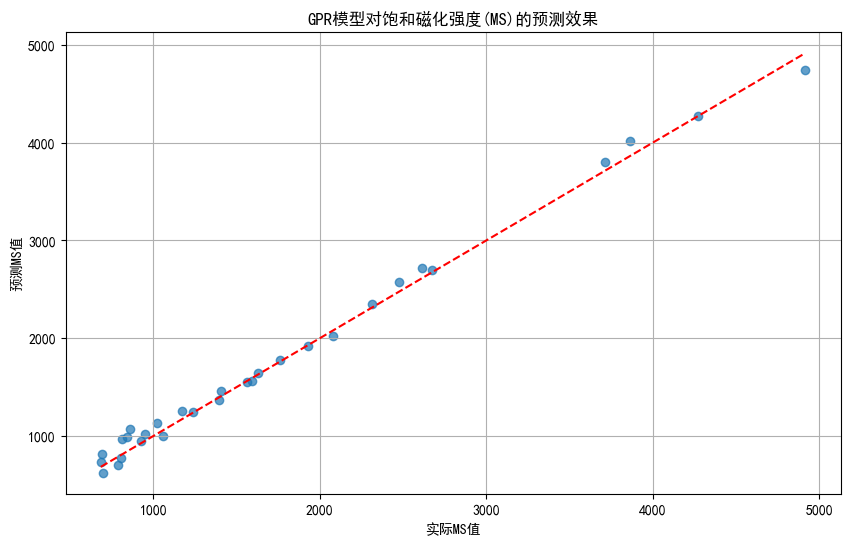

最优超参数: {'estimator__kernel': 1**2 * RBF(length_scale=1), 'estimator__n_restarts_optimizer': 5}
最优交叉验证分数: 18261.8246


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# 定义核函数（公式中的σ²对应ConstantKernel，RBF对应R(·)）
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# 构建多输出GPR模型
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,  # 优化超参数的重启次数
    normalize_y=True  # 标准化目标值
)
multi_output_gpr = MultiOutputRegressor(gpr)

# 训练模型
multi_output_gpr.fit(X_train, Y_train)

# 预测
Y_pred = multi_output_gpr.predict(X_test)

# 评估模型性能（对Y1和Y2分别评估）
for i in range(2):
    y_test = Y_test[:, i]
    y_pred = Y_pred[:, i]
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"输出变量{['MS', 'HcJ'][i]}的评估：")
    print(f"均方误差(MSE): {mse:.4f}")
    print(f"决定系数(R²): {r2:.4f}")

# 可视化预测结果（以MS为例）
plt.figure(figsize=(10, 6))
plt.scatter(Y_test[:, 0], Y_pred[:, 0], alpha=0.7)
plt.plot([Y_test[:, 0].min(), Y_test[:, 0].max()], 
         [Y_test[:, 0].min(), Y_test[:, 0].max()], 'r--')
plt.xlabel('实际MS值')
plt.ylabel('预测MS值')
plt.title('GPR模型对饱和磁化强度(MS)的预测效果')
plt.grid(True)
plt.show()

# 超参数优化（可选）
param_grid = {
    'estimator__kernel': [
        C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)),
        C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-1, 1e1)) + C(0.1, (1e-4, 1e-1))
    ],
    'estimator__n_restarts_optimizer': [5, 10]
}

grid_search = GridSearchCV(
    multi_output_gpr,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, Y_train)
print(f"最优超参数: {grid_search.best_params_}")
print(f"最优交叉验证分数: {(-grid_search.best_score_):.4f}")